In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'/disk/u/gio/mechinterp/analogies5/notebooks'

In [7]:
# === 1. Imports & parameters ===
from pathlib import Path
import json, re, time

import pandas as pd
import matplotlib.pyplot as plt

# ---- Params (edit me) ----
DATA_PATH = Path("../data/relation_selection_dataset_v2.jsonl")   # your new dataset path
MODEL_NAME = "meta-llama/Llama-3.3-70B-Instruct"     # change if you want smaller
MAX_NEW_TOKENS = 4
DRY_RUN = False
LIMIT = None       # e.g., 200 for a quick run
OUT_CSV = Path("../data/beginner_eval_details.csv")

INSTRUCTION = "Finish the analogy in one word.\n"

In [4]:
# === 2. Utilities ===
def read_jsonl(path, limit=None):
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            items.append(json.loads(line))
            if limit and len(items) >= limit:
                break
    return items

def canonicalize(token: str) -> str:
    s = token.strip().lower()
    s = re.sub(r"[\s'\"“”‘’`]+", " ", s)
    s = s.split()[0] if s else ""
    s = re.sub(r"[^\w-]+$", "", s)
    return s

def build_prompt(ex):
    # story and analogy already in the JSONL
    return f"""{INSTRUCTION}{ex['story']}

{ex['analogy']}"""

In [8]:
# === 3. Load dataset ===
items = read_jsonl(DATA_PATH, limit=LIMIT)
print(f"Loaded {len(items)} items from {DATA_PATH}")
print("Preview:")
for ex in items[:3]:
    print(json.dumps(ex, ensure_ascii=False))

Loaded 1200 items from ../data/relation_selection_dataset_v2.jsonl
Preview:
{"story": "The sculpture is crafted out of clay. The vase is housed in the park. The sculpture is inside the gallery. The vase is made of marble.", "prompt": "", "analogy": "vase is to marble as sculpture is to", "answer": "clay", "meta": {"relation_target": "made of", "relation_distractor_family": "located in", "surface_r1_s1": "made of", "surface_r1_s2": "crafted out of", "surface_r2_s1": "housed in", "surface_r2_s2": "inside", "r1_synonyms_distinct": true, "sentences_shuffled": true, "lexicon_condition": "real", "s1_noun_type": "real", "s2_noun_type": "real", "seed": 23, "template": "S1:O1::S2:?", "task": "Task-2 (S→O)"}}
{"story": "The statue is resting on the shelf. The jar is perched on the table. The jar is made of bronze. The statue is constructed from glass.", "prompt": "", "analogy": "bronze is to jar as glass is to", "answer": "statue", "meta": {"relation_target": "made of", "relation_distractor_fami

In [9]:
# === 4. Load model (skipped if DRY_RUN) ===
tokenizer = None
model = None

if not DRY_RUN:
    from transformers import AutoTokenizer, AutoModelForCausalLM
    print(f"Loading tokenizer: {MODEL_NAME}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, trust_remote_code=True)
    print(f"Loading model: {MODEL_NAME}")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        torch_dtype="auto",
        trust_remote_code=True,
    ).eval()
else:
    print("DRY_RUN=True → skipping model load")

/disk/u/gio/.conda/envs/retrieval2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading tokenizer: meta-llama/Llama-3.3-70B-Instruct
Loading model: meta-llama/Llama-3.3-70B-Instruct


Loading checkpoint shards: 100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


In [10]:
# === 5. Generate (greedy) ===
def model_generate(prompt: str, max_new_tokens: int = 4) -> str:
    if DRY_RUN:
        return ""
    enc = tokenizer(prompt, return_tensors="pt")
    enc = {k: v.to(model.device) for k, v in enc.items()}
    out = model.generate(
        **enc,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        temperature=None,
        top_p=None,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    txt = tokenizer.decode(out[0][enc["input_ids"].shape[1]:], skip_special_tokens=True)
    return txt.strip()

In [13]:
# === Evaluation loop (relation-selection v2) ===
import time, json, re
import pandas as pd

def canonicalize(token: str) -> str:
    s = token.strip().lower()
    s = re.sub(r"[\s'\"“”‘’`]+", " ", s)
    s = s.split()[0] if s else ""
    s = re.sub(r"[^\w-]+$", "", s)
    return s

def read_jsonl(path, limit=None):
    items = []
    with open(path, "r") as f:
        for line in f:
            if not line.strip(): continue
            items.append(json.loads(line))
            if limit and len(items) >= limit:
                break
    return items

INSTRUCTION = "Finish the analogy in one word.\n"
def build_prompt(ex):
    return f"{INSTRUCTION}{ex['story']}\n\n{ex['analogy']}"

items = read_jsonl(DATA_PATH, limit=LIMIT)
print(f"Loaded {len(items)}")

preds, golds, rows = [], [], []
t0 = time.time()

for idx, ex in enumerate(items, 1):
    prompt = build_prompt(ex)
    if DRY_RUN:
        raw = ex["answer"]
    else:
        raw = model_generate(prompt, max_new_tokens=MAX_NEW_TOKENS)

    pred = canonicalize(raw)
    gold = canonicalize(ex["answer"])

    print(f"Example {idx}")
    print("Correct Answer:", gold)
    print("Prediction:", pred)
    print()

    m = ex.get("meta", {})
    rows.append({
        "idx": idx-1,
        "task": m.get("task",""),
        "template": m.get("template",""),
        "lexicon_condition": m.get("lexicon_condition",""),
        "distractor_family": m.get("relation_distractor_family",""),
        "story": ex.get("story",""),
        "analogy": ex.get("analogy",""),
        "gold_raw": ex.get("answer",""),
        "pred_raw": raw,
        "gold": gold,
        "pred": pred,
        "correct": int(pred == gold),
    })

    if idx % 50 == 0:
        print(f"Processed {idx}/{len(items)} in {time.time()-t0:.1f}s")

print("Done.")
df = pd.DataFrame(rows)
acc = df["correct"].mean()
print(f"Total: {len(df)} | EM@1: {acc:.3f} | DRY_RUN={DRY_RUN}")
display(df.head(8))

Loaded 1200
Example 1
Correct Answer: clay
Prediction: _______

Example 2
Correct Answer: statue
Prediction: statue

Example 3
Correct Answer: ixoqomiw
Prediction: ixoqomiw

Example 4
Correct Answer: aspesp
Prediction: aspesp

Example 5
Correct Answer: difriq
Prediction: difriq

Example 6
Correct Answer: cup
Prediction: cup

Example 7
Correct Answer: daplex
Prediction: _______________________

Example 8
Correct Answer: lafabado
Prediction: lafabado

Example 9
Correct Answer: stimo
Prediction: stimo

Example 10
Correct Answer: kiosk
Prediction: _______

Example 11
Correct Answer: bronze
Prediction: _______________________

Example 12
Correct Answer: clacralo
Prediction: clacralo

Example 13
Correct Answer: gurecig
Prediction: _______

Example 14
Correct Answer: drutucoju
Prediction: drutucoju

Example 15
Correct Answer: clay
Prediction: clay

Example 16
Correct Answer: artifact
Prediction: _______

Example 17
Correct Answer: resin
Prediction: resin

Example 18
Correct Answer: cayud
Pred

,idx,task,template,lexicon_condition,distractor_family,story,analogy,gold_raw,pred_raw,gold,pred,correct
0,0,Task-2 (S→O),S1:O1::S2:?,real,located in,The sculpture is crafted out of clay. The vase...,vase is to marble as sculpture is to,clay,_______\n\n## Step,clay,_______,0
1,1,Task-1 (O→S),O1:S1::O2:?,real,rests on,The statue is resting on the shelf. The jar is...,bronze is to jar as glass is to,statue,statue\n\nThe word,statue,statue,1
2,2,Task-3 (O→O across),S2:O2::S1:?,fake,rests on,The ivomabruk is placed on the cruyutro. The i...,ayoglagr is to clithisk as ivomabruk is to,ixoqomiw,ixoqomiw,ixoqomiw,ixoqomiw,1
3,3,Task-4 (S→S across),O2:S2::O1:?,fake,located in,The huprafob is situated in the bodraqimi. The...,dustaju is to huprafob as yixic is to,aspesp,aspesp,aspesp,aspesp,1
4,4,Task-2 (S→O),S1:O1::S2:?,mixed,located in,The cup is made of resin. The xezuda is compos...,cup is to resin as xezuda is to,difriq,difriq as,difriq,difriq,1
5,5,Task-1 (O→S),O1:S1::O2:?,real,rests on,The cup is perched on the desk. The statue is ...,marble is to statue as clay is to,cup,cup\n\nThe word,cup,cup,1
6,6,Task-3 (O→O across),S2:O2::S1:?,fake,rests on,The spuge is sitting on the otumequwe. The ine...,spuge is to biqexibre as inetrav is to,daplex,_______________________\n\nAnswer,daplex,_______________________,0
7,7,Task-4 (S→S across),O2:S2::O1:?,mixed,rests on,The lafabado is made of ewaloplak. The lafabad...,steel is to bench as ewaloplak is to,lafabado,lafabado,lafabado,lafabado,1


<Figure size 640x480 with 0 Axes>

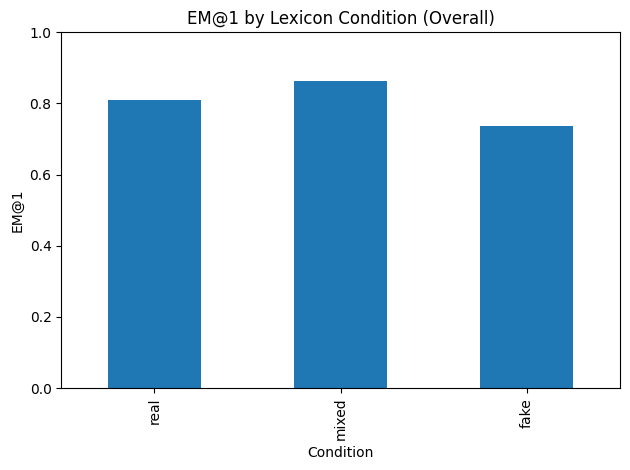

,EM@1
lexicon_condition,
real,0.8100
mixed,0.8625
fake,0.7375


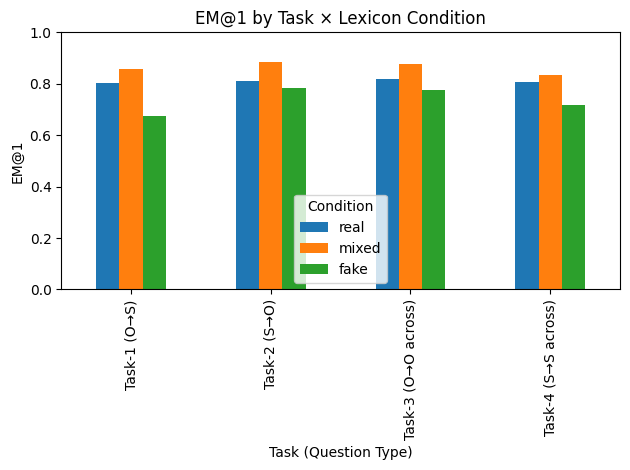

,task,lexicon_condition,correct
0,Task-1 (O→S),fake,0.672897
1,Task-1 (O→S),mixed,0.855670
2,Task-1 (O→S),real,0.802083
3,Task-2 (S→O),fake,0.781818
4,Task-2 (S→O),mixed,0.882979
5,Task-2 (S→O),real,0.812500
6,Task-3 (O→O across),fake,0.776596
7,Task-3 (O→O across),mixed,0.877358
8,Task-3 (O→O across),real,0.820000
9,Task-4 (S→S across),fake,0.719101


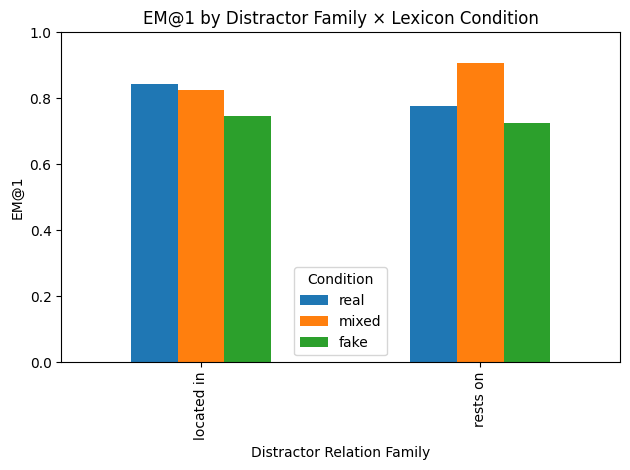

,distractor_family,lexicon_condition,correct
0,located in,fake,0.747664
1,located in,mixed,0.826484
2,located in,real,0.843137
3,rests on,fake,0.725806
4,rests on,mixed,0.906077
5,rests on,real,0.775510


Wrote summary_overall_condition.csv, summary_task_x_condition.csv, summary_distractor_x_condition.csv


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Consistent orders
cond_order = ["real", "mixed", "fake"]
task_order = ["Task-1 (O→S)", "Task-2 (S→O)", "Task-3 (O→O across)", "Task-4 (S→S across)"]
r2_order   = ["located in", "rests on"]

# 1) Overall by condition
overall = (
    df.groupby("lexicon_condition")["correct"]
      .mean()
      .reindex(cond_order)
      .to_frame("EM@1")
)

plt.figure()
overall.plot(kind="bar", legend=False)
plt.title("EM@1 by Lexicon Condition (Overall)")
plt.xlabel("Condition")
plt.ylabel("EM@1")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
display(overall)

# 2) Task × condition (grouped bars)
per_task = (
    df.groupby(["task","lexicon_condition"])["correct"]
      .mean()
      .reset_index()
)
pivot_task = (
    per_task.pivot(index="task", columns="lexicon_condition", values="correct")
            .reindex(index=task_order, columns=cond_order)
            .fillna(0.0)
)

ax = pivot_task.plot(kind="bar")
plt.title("EM@1 by Task × Lexicon Condition")
plt.xlabel("Task (Question Type)")
plt.ylabel("EM@1")
plt.ylim(0, 1)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()
display(per_task.sort_values(["task","lexicon_condition"]))

# 3) Distractor family × condition (optional but requested)
per_r2 = (
    df.groupby(["distractor_family","lexicon_condition"])["correct"]
      .mean()
      .reset_index()
)
pivot_r2 = (
    per_r2.pivot(index="distractor_family", columns="lexicon_condition", values="correct")
          .reindex(index=r2_order, columns=cond_order)
          .fillna(0.0)
)

ax = pivot_r2.plot(kind="bar")
plt.title("EM@1 by Distractor Family × Lexicon Condition")
plt.xlabel("Distractor Relation Family")
plt.ylabel("EM@1")
plt.ylim(0, 1)
plt.legend(title="Condition")
plt.tight_layout()
plt.show()
display(per_r2.sort_values(["distractor_family","lexicon_condition"]))

# 4) Save summaries (nice for slides)
overall.reset_index().rename(columns={"index":"lexicon_condition","correct":"em1"}).to_csv("summary_overall_condition.csv", index=False)
pivot_task.to_csv("summary_task_x_condition.csv")
pivot_r2.to_csv("summary_distractor_x_condition.csv")
print("Wrote summary_overall_condition.csv, summary_task_x_condition.csv, summary_distractor_x_condition.csv")

In [ ]:
# (Optional) Most common wrong answers
wrong = (
    df[df["correct"] == 0]
      .groupby(["template","gold","pred"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)
display(wrong.head(20))